In [3]:
import numpy as np
import pandas as pd

In [4]:
# loading dataset
data = pd.read_csv('./data/currentWaitingTime.csv')
data.columns =  ['airport','day_of_month', 'day', 'gate', 'hour', 'minutes', 'second', 'waiting_time']

In [5]:
# Let's peek into the whole dataset
data.head(10)

,airport,day_of_month,day,gate,hour,minutes,second,waiting_time
0,ewr,17,Thursday,middle,9,18,54,4.179369
1,ewr,17,Thursday,south,9,18,54,6.034359
2,ewr,17,Thursday,north,9,18,55,28.073839
3,ewr,17,Thursday,south,9,18,55,32.538698
4,ewr,17,Thursday,middle,9,18,55,13.583811
5,ewr,17,Thursday,south,9,18,56,67.028434
6,ewr,17,Thursday,middle,9,18,56,28.895787
7,ewr,17,Thursday,north,9,18,56,55.911928
8,ewr,17,Thursday,north,9,18,57,77.996640
9,ewr,17,Thursday,south,9,18,57,89.617857


In [6]:
data.tail(10)

,airport,day_of_month,day,gate,hour,minutes,second,waiting_time
793,ewr,17,Thursday,south,9,23,8,551.055954
794,ewr,17,Thursday,middle,9,23,9,539.853245
795,ewr,17,Thursday,north,9,23,9,672.930235
796,ewr,17,Thursday,south,9,23,9,552.260532
797,ewr,17,Thursday,north,9,23,10,674.774810
798,ewr,17,Thursday,middle,9,23,10,544.014649
799,ewr,17,Thursday,south,9,23,10,554.579829
800,ewr,17,Thursday,north,9,23,11,677.858601
801,ewr,17,Thursday,south,9,23,11,554.616011
802,ewr,17,Thursday,middle,9,23,11,545.317097


In [7]:
## list available gate types 
print data['gate'].unique()

['middle' 'south' 'north']


In [8]:
## creating sub-datasets for middle, south and north gates
data_south = data[data['gate'] == 'south']
data_middle = data[data['gate'] == 'middle']
data_north = data[data['gate'] == 'north']

In [9]:
data_south.count()

airport         266
day_of_month    266
day             266
gate            266
hour            266
minutes         266
second          266
waiting_time    266
dtype: int64

In [10]:
data_north.count()

airport         271
day_of_month    271
day             271
gate            271
hour            271
minutes         271
second          271
waiting_time    271
dtype: int64

In [11]:
190data_middle.count()

airport         266
day_of_month    266
day             266
gate            266
hour            266
minutes         266
second          266
waiting_time    266
dtype: int64

In [12]:
print data_north['day'].unique()
print data_north['day_of_month'].unique()

['Thursday']
[17]


In [13]:
## Let's take north gate dataset and build a model.
## Frist build a model using all featues and considering featues are categorical
data_north_encoded = pd.concat([pd.get_dummies(data_north['hour'], prefix='h'), 
                                pd.get_dummies(data_north['minutes'],  prefix='m'),
                                pd.get_dummies(data_north['second'], prefix='d')], axis=1)

X_data = data_north_encoded.values
y_data = data_north['waiting_time'].values

In [15]:
## Helper function 
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

def show_graph(y_true, y_pred):    
    x_values = np.linspace(1, y_true.shape[0], y_true.shape[0])
    plt.plot(x_values, y_true, label="actual", linewidth=2)
    if y_pred is not None:
        plt.plot(x_values, y_pred, label="predicted", linewidth=2)
    plt.legend()
    plt.ylabel('average waiting time')
    plt.show()   

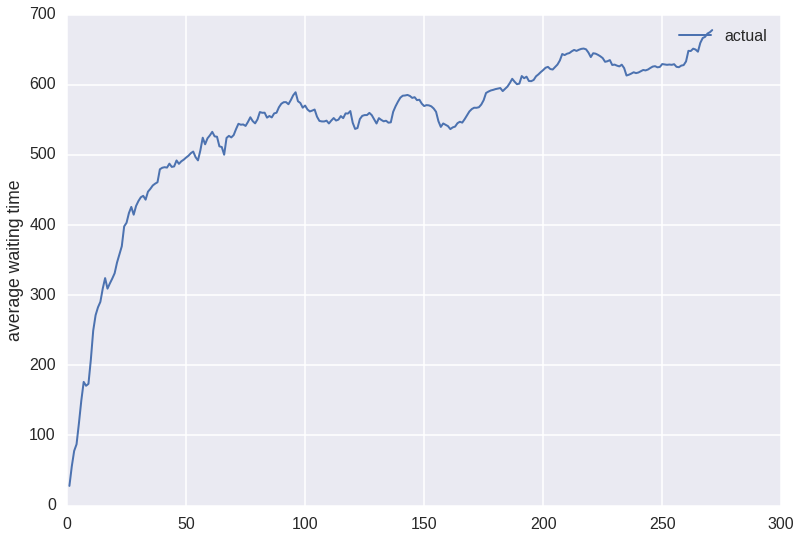

In [207]:
show_graph(y_data, None)

In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train = X_data[:190, :]
y_train = y_data[:190]
X_test =  X_data[190:, :]
y_test = y_data[190:]

gbr = RandomForestRegressor(n_estimators=25)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print "mean squared error: %.3f" %(mean_squared_error(y_test, y_pred))

mean squared error: 5947.322


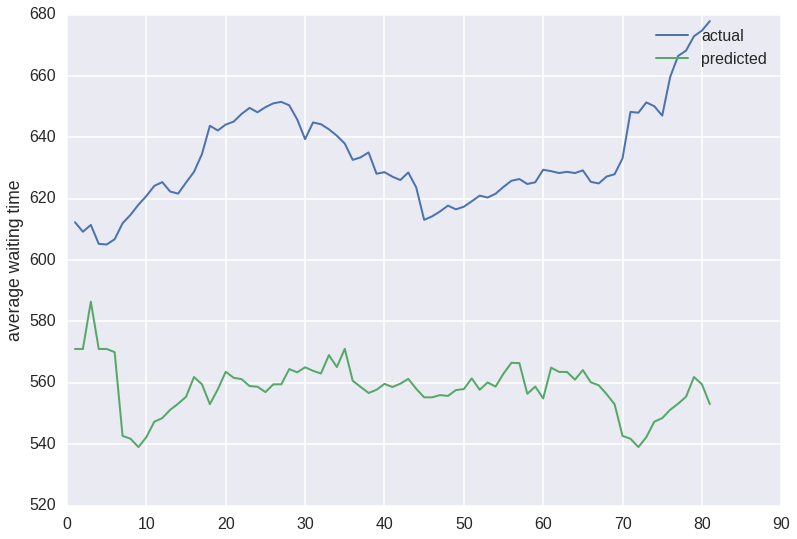

In [209]:
show_graph(y_test, y_pred)

In [26]:
def rolling_univariate_window(time_series, window_size):    
    shape = (time_series.shape[0] - window_size + 1, window_size)  
    strides = time_series.strides + (time_series.strides[-1],)
    return np.lib.stride_tricks.as_strided(time_series, shape=shape, strides=strides)


def build_rolling_window_dataset(time_series, window_size):
    last_element = time_series[-1]
    time_series = time_series[:-1]
    X_train = rolling_univariate_window(time_series, window_size)
    y_train = np.array([X_train[i, window_size-1] for i in range(1, X_train.shape[0])])
    
    return X_train, np.hstack((y_train, last_element))

def train_test_split(no_of_training_instances, X_all, y_all):
    X_train = X_all[0:no_of_training_instances, :]
    X_test = X_all[no_of_training_instances:, :]
    y_train = y_all[0:no_of_training_instances]
    y_test = y_all[no_of_training_instances:]
    
    return X_train, X_test, y_train, y_test

def print_graph(X_all, X_test, y_all, y_test, y_pred):
    training_size = X_all.shape[0] - X_test.shape[0]
    x_full_limit = np.linspace(1, X_all.shape[0], X_all.shape[0])
    y_pred_limit = np.linspace(training_size+1, training_size + 1 + X_test.shape[0], X_test.shape[0])
    plt.plot(x_full_limit, y_all, label='actual', color='b', linewidth=1)
    plt.plot(y_pred_limit, y_pred, '--', color='r', linewidth=2, label='prediction')
    plt.legend(loc=0)
    plt.show()

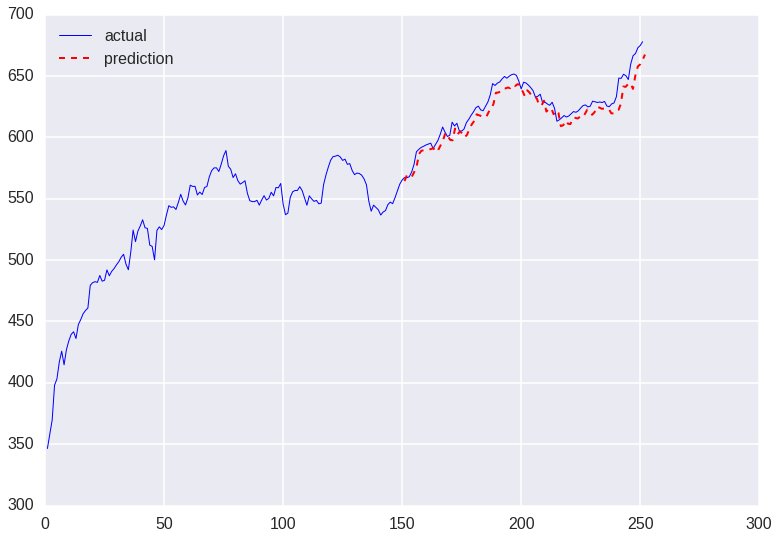

In [29]:
from sklearn.linear_model import LinearRegression

X_features, y_responses = build_rolling_window_dataset(y_data, 20)
X_train, X_test, y_train, y_test = train_test_split(150, X_features, y_responses)
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print_graph(X_features, X_test, y_responses, y_test, y_pred)